### Practical Section

In this section, we will be looking into one of the practical reinforcement learning problems populary known as the Cartpole Problem using OpenAI Gym for our learning environment.\
The cartpole problem consists of an inverted pendulum mounted on a cart. At any given state, the environment returns four observations to the agent. These observations are the position of the cart, velocity of the cart, angle of the pole and lastly the angular velocity of the pole. The agent using these observations has to decide on one of two possible actions, either move the cart to the left  or right. 
The goal of the agent is to balance the pole and keep it balanced for longer period of time. The agent recieves a  reward of +1 at each time step its able to keep the pole upright and -1 if it fails. The environment returns 'done' if the agent fails to balance the pole or if the maximum time-step for an episode is reached. In the cartpole environment,the agent fails to balance:

1. if the angle of the pole is greater than $\pm 12^{\circ}$ 
2. Cart position is exceeds $\pm 2.4$


$\bullet$ We will build our agent a using neural network  in this case  to represent the action value function(Q,values).  Therefore the underlying algorithm here is the Q-learning algorithm and hence the update rule for our Q values is:
\begin{equation}
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \big[R_{t+1} + \gamma \max_a Q(s_{t+1},a) - Q(s,a) \big] 
\end{equation}
$\bullet$ The agent will be trained using $\epsilon$-greedy exploration. \
$\bullet$ We will be using Cartpole version 1(CartPole-v1)\
$\bullet$ We will set our maximum step per epiode to 450 since CartPole-v1 comes with a default maximum step of 500


### Importing modules

In [1]:
t_seed = 0

In [2]:
import random
random.seed(t_seed)
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import  Adam
import gym
from collections import deque
from statistics import mean
%matplotlib inline

#%tensorflow_version 1.x

Using Theano backend.


We build our deep learning, store its experiences in a buffer and train it using samples from the stored experiences and this what we referr to as Experience Replay.

In [3]:
batch_size = 128
num_episodes = 1000 #number of episodes

In [4]:
class DQNAgent:
    def __init__(self): 
        #self.state_size = state_size
        #self.action_size = action_size
        self.memory = deque(maxlen=5000) 
        self.discount_rate = 0.99 
        self.explore_rate = 1 
        self.decay_rate = 0.99
        self.min_explore_rate = 0.1 
        self.learning_rate = 0.001
        self.env_t3 = gym.make('CartPole-v1')
        self.env_t3.seed(t_seed)
        self.state_size = self.env_t3.observation_space.shape[0]
        self.action_size = self.env_t3.action_space.n
        self.env_t3.action_space.seed(t_seed)
        self.model = self._network_model()
        self.target_model = self._network_model()
        
    def _network_model(self):
        # neural network to approximate Q-value function:
        model = Sequential()
        np.random.seed(t_seed)
        model.add(Dense(64, input_dim=self.state_size, activation='relu')) 
        model.add(Dense(64, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear')) 
        model.compile(loss='mean_squared_error',optimizer=Adam(lr=self.learning_rate))
        model.summary()

        return model

    def update_target_model(self, time):
        # setting weights from model to target_model
        if time != 0:
            if num_episodes % time == 0:
                self.target_model.set_weights(self.model.get_weights())

    
    def memory_track(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) 

    def choose_action(self, state):
        np.random.seed(t_seed)
        if np.random.rand() <= self.explore_rate: 
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0]) 

    def experience_replay(self, batch_size): 
        loss = []
        mini_batch = random.sample(self.memory, batch_size) 
        for state, action, reward, next_state, done in mini_batch: 
            Target = reward 
            if not done: 
                Target = (reward + self.discount_rate * np.amax(self.target_model.predict(next_state)[0]))
            value_target = self.model.predict(state) 
            value_target[0][action] = Target
            np.random.seed(t_seed)
            history = self.model.fit(state, value_target , epochs=1, verbose=0)
            loss.append(history.history['loss'][0])
            #print(type(hist))
        if self.explore_rate  > self.min_explore_rate :
            self.explore_rate  *= self.decay_rate
        return loss

            
    def Train(self) :
        i = 0
        all_rewards=[]
        err = []
        done = False
        over_time_step =[] #list of the episodes in which the agent was able to keep the pole upright for 450 time_step
        for episode in range(num_episodes): 
            state = self.env_t3.reset() 
            state = np.reshape(state, [1, self.state_size])
            episode_reward = 0
            for time in range(450): 
                self.env_t3.render()
                action = self.choose_action(state) 
                next_state, reward, done, _ = self.env_t3.step(action)        
                episode_reward += reward if not done else -1
                next_state = np.reshape(next_state, [1, self.state_size])
                self.memory_track(state, action, reward, next_state, done)
                self.update_target_model(time)
                state = next_state 
                if done: 
                    print("episode: {}/{}, reward: {}" .format(episode, num_episodes, episode_reward))
                    i=i+1
                    break
            if episode_reward == 450:
                over_time_step.append(episode)
                 
            all_rewards.append(episode_reward) 
            
            if len(self.memory) > batch_size:
                experience = self.experience_replay(batch_size) # we train the agent by replaying the experiences of the episode
                err.append(experience) 
        
    
    
        print('Maximum reward obatined is {} in episode {}'.format(max(all_rewards), all_rewards.index(max(all_rewards))))
        print(over_time_step)
        print(i)
        self.env_t3.close()
        
        return all_rewards,err
    
    
    
        
if __name__ == "__main__":
    Cartpole_agent = DQNAgent() # initializing agent
    train_agent = Cartpole_agent.Train()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


episode: 8/1000, reward: 37.0
episode: 9/1000, reward: 42.0
episode: 10/1000, reward: 15.0
episode: 11/1000, reward: 26.0
episode: 12/1000, reward: 72.0
episode: 13/1000, reward: 13.0
episode: 14/1000, reward: 26.0
episode: 15/1000, reward: 39.0
episode: 16/1000, reward: 15.0
episode: 17/1000, reward: 12.0
episode: 18/1000, reward: 16.0
episode: 19/1000, reward: 43.0
episode: 20/1000, reward: 24.0
episode: 21/1000, reward: 31.0
episode: 22/1000, reward: 10.0
episode: 23/1000, reward: 21.0
episode: 24/1000, reward: 22.0
episode: 25/1000, reward: 12.0
episode: 26/1000, reward: 25.0
episode: 27/1000, reward: 10.0
episode: 28/1000, reward: 11.0
episode: 29/1000, reward: 8.0
episode: 30/1000, reward: 20.0
episode: 31/1000, reward: 13.0
episode: 32/1000, reward: 8.0
episode: 33/1000, reward: 22.0
episode: 34/1000, reward: 14.0
episode: 35/1000, reward: 27.0
episode: 36/1000, reward: 26.0
episode: 37/1000, reward: 31.0
episode: 38/1000, reward: 28.0
episode: 39/1000, reward: 15.0
episode: 40/

episode: 446/1000, reward: 360.0
episode: 449/1000, reward: 174.0
episode: 450/1000, reward: 342.0
episode: 452/1000, reward: 448.0
episode: 453/1000, reward: 169.0
episode: 454/1000, reward: 347.0
episode: 507/1000, reward: 385.0
episode: 511/1000, reward: 332.0
episode: 515/1000, reward: 144.0
episode: 516/1000, reward: 8.0
episode: 517/1000, reward: 109.0
episode: 518/1000, reward: 114.0
episode: 519/1000, reward: 216.0
episode: 520/1000, reward: 230.0
episode: 521/1000, reward: 200.0
episode: 522/1000, reward: 178.0
episode: 523/1000, reward: 172.0
episode: 524/1000, reward: 7.0
episode: 525/1000, reward: 7.0
episode: 526/1000, reward: 7.0
episode: 527/1000, reward: 6.0
episode: 528/1000, reward: 8.0
episode: 529/1000, reward: 7.0
episode: 530/1000, reward: 7.0
episode: 531/1000, reward: 220.0
episode: 532/1000, reward: 8.0
episode: 533/1000, reward: 9.0
episode: 534/1000, reward: 8.0
episode: 535/1000, reward: 8.0
episode: 536/1000, reward: 8.0
episode: 537/1000, reward: 119.0
epi

In [14]:
 #env_d.close()#for closing the pop-up screen 

In [ ]:
#score = [(np.array(train_agent[0][i])) for i in range(len(train_agent[0]))]

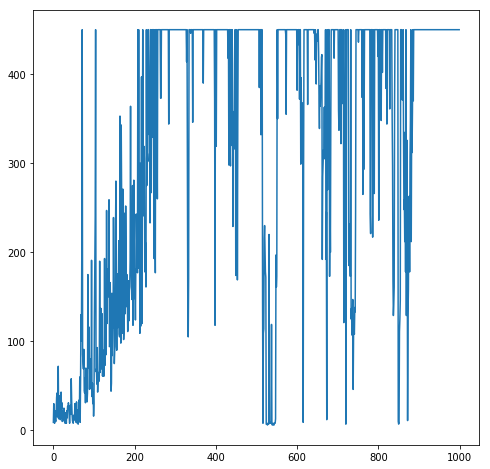

In [5]:
#plotting the rewards
plt.figure(figsize=(8, 8))
plt.plot(np.array(train_agent[0]))
plt.savefig('cartpole_DQN_target_main3')

In [6]:
#smoothing the rewards
s = []
a_r = np.zeros(50)

for i in range(0,1000,20):
    a_r = sum(np.array(train_agent[0])[i:i+20])
    s.append(a_r)


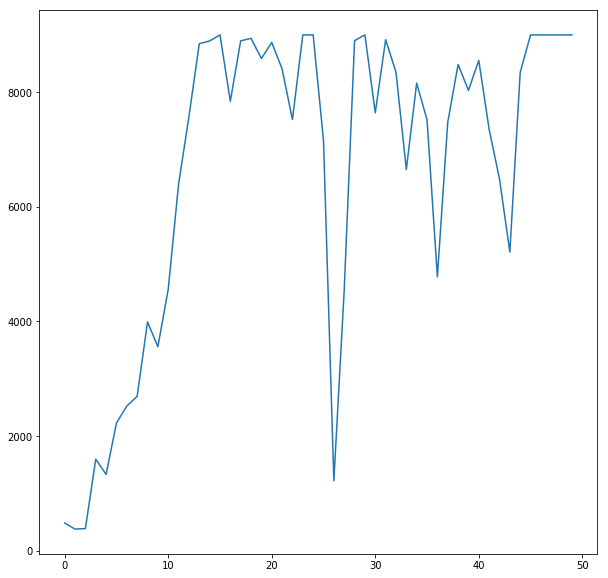

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(np.array(s))
plt.savefig('cartpole_DQN_target_main3_smoothed')

In [8]:
#smoothing the rewards with mean
s2 = []
a_r2 = np.zeros(50)

for i in range(0,1000,20):
    a_r2 = np.mean(np.array(train_agent[0])[i:i+20])
    s2.append(a_r2)
    
    
    

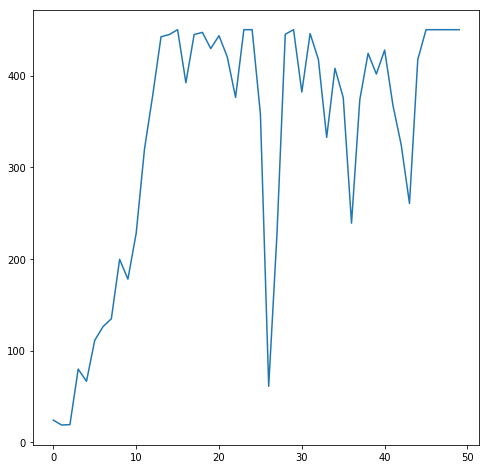

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(np.array(s2))
plt.savefig('cartpole_DQN_target_main3_smoothed2')

In [10]:
#finding the mean of losses for each episode
mean_err = [np.mean(np.array(train_agent[1][i])) for i in range(len(train_agent[1]))]

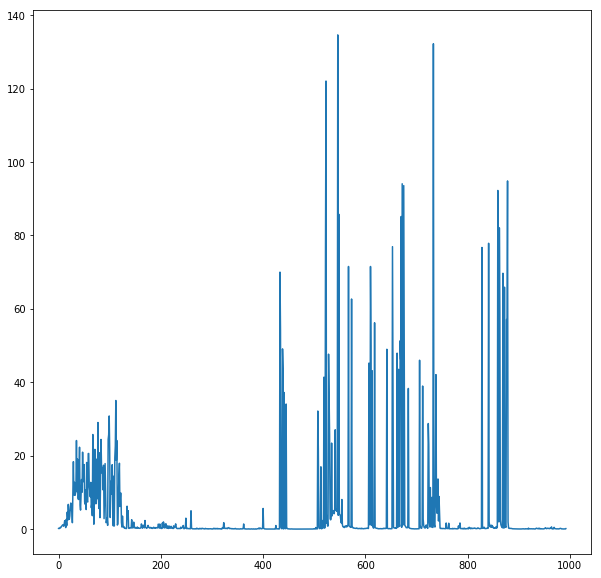

In [11]:
#plotting the mean error
plt.figure(figsize=(10, 10))
plt.plot(np.array(mean_err))
plt.savefig('cartpole_DQN_error_target_main3')